<a href="https://colab.research.google.com/github/AdityaPunetha/TensorFlow-CIFAR10-GAN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [62]:
from numpy import zeros, ones
from numpy.random import randn, randint
import numpy as np
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt

%matplotlib inline

In [92]:
from tensorflow.saved_model import save

# Load data

In [63]:
(trainX, trainy), (testX, testy) = load_data()

In [64]:
print(len(trainX), len(testX))

50000 10000


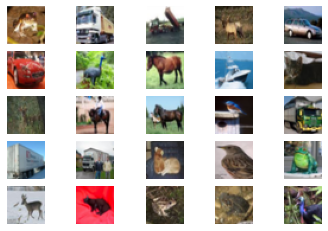

In [65]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis("off")
    plt.imshow(trainX[i])
plt.show()

In [66]:
trainX[0].shape

(32, 32, 3)

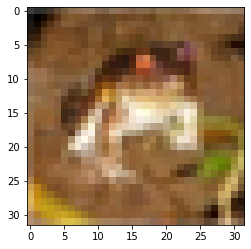

In [67]:
plt.imshow(trainX[0])

In [68]:
def denorm(x):
    out = (x + 1) / 2
    return out

# Define Discriminator

In [69]:
in_shape = (32, 32, 3)

discriminator = Sequential()

discriminator.add(
    layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same", input_shape=in_shape)
)
discriminator.add(layers.LeakyReLU(alpha=0.2))

discriminator.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
discriminator.add(layers.LeakyReLU(alpha=0.2))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Dense(1, activation="sigmoid"))

opt = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [70]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                

# Define Generator

In [71]:
latent_size = 100

In [72]:
generator = Sequential()

n_nodes = 128 * 8 * 8
generator.add(layers.Dense(n_nodes, input_dim=latent_size))
generator.add(layers.ReLU())
generator.add(layers.Reshape((8, 8, 128)))

generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
generator.add(layers.ReLU())

generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
generator.add(layers.ReLU())

generator.add(layers.Conv2D(3, (8, 8), activation="tanh", padding="same"))

In [73]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 re_lu_3 (ReLU)              (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 re_lu_4 (ReLU)              (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [74]:
y = generator(randn(1, latent_size))

In [75]:
gen_image = y

In [76]:
gen_image = gen_image.numpy()

In [77]:
gen_image = denorm(gen_image)

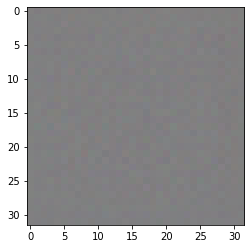

In [78]:
plt.imshow(gen_image[0])

# Discriminator Training

In [79]:
batch_size = 100

In [80]:
real_labels = ones((batch_size, 1))
real_labels.shape

(100, 1)

In [81]:
def train_discriminator(images):
    real_labels = ones((batch_size, 1))
    fake_labels = zeros((batch_size, 1))

    d_loss_real, _ = discriminator.train_on_batch(images, real_labels)

    generated_images = generator(randn(batch_size, latent_size))

    d_loss_fake, _ = discriminator.train_on_batch(generated_images, fake_labels)

    d_loss = d_loss_fake + d_loss_real

    return d_loss, d_loss_fake, d_loss_real

# Generator Training

In [82]:
def define_gan(generator, discriminator):
    discriminator.trainable = (
        False  # Discriminator is trained separately. So set to not trainable.
    )
    # connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

# Training the model

In [83]:
# sample_dir = 'samples'
# if not os.path.exists(sample_dir):
#     os.makedirs(sample_dir)

In [84]:
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    X = dataset[ix]
    return X

In [85]:
dataset = (trainX - 127.5) / 127.5

In [86]:
total_step = len(dataset)

In [87]:
bat_per_epo = int(dataset.shape[0] / batch_size)

In [88]:
bat_per_epo

500

In [89]:
gan_model = define_gan(generator, discriminator)

In [90]:
# %%time

num_epochs = 50
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i in range(bat_per_epo):
        X_real = generate_real_samples(dataset, batch_size)

        d_loss, d_loss_fake, d_loss_real = train_discriminator(X_real)

        g_loss = gan_model.train_on_batch(
            randn(batch_size, latent_size), ones((batch_size, 1))
        )

        if (i + 1) % 200 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}".format(
                    epoch, num_epochs, i + 1, bat_per_epo, d_loss, g_loss
                )
            )

Epoch [0/50], Step [200/500], d_loss: 0.6567, g_loss: 1.1446
Epoch [0/50], Step [400/500], d_loss: 1.0841, g_loss: 1.1581
Epoch [1/50], Step [200/500], d_loss: 0.7188, g_loss: 1.3084
Epoch [1/50], Step [400/500], d_loss: 0.9733, g_loss: 1.6248
Epoch [2/50], Step [200/500], d_loss: 1.5394, g_loss: 1.2193
Epoch [2/50], Step [400/500], d_loss: 1.0049, g_loss: 1.5482
Epoch [3/50], Step [200/500], d_loss: 1.3797, g_loss: 1.0501
Epoch [3/50], Step [400/500], d_loss: 1.5436, g_loss: 0.6828
Epoch [4/50], Step [200/500], d_loss: 1.1904, g_loss: 1.1875
Epoch [4/50], Step [400/500], d_loss: 1.3701, g_loss: 0.8532
Epoch [5/50], Step [200/500], d_loss: 1.1244, g_loss: 1.1292
Epoch [5/50], Step [400/500], d_loss: 1.5220, g_loss: 0.7568
Epoch [6/50], Step [200/500], d_loss: 1.2101, g_loss: 1.1277
Epoch [6/50], Step [400/500], d_loss: 1.1746, g_loss: 0.8956
Epoch [7/50], Step [200/500], d_loss: 1.3264, g_loss: 0.8348
Epoch [7/50], Step [400/500], d_loss: 1.3042, g_loss: 1.0165
Epoch [8/50], Step [200/

# Post training

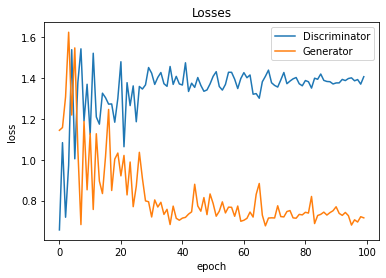

In [91]:
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

In [94]:
generator.save("G.h5")

In [96]:
save(generator, "generator")

INFO:tensorflow:Assets written to: generator/assets


In [97]:
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis("off")
        plt.imshow(examples[i, :, :, :])
    plt.show()

In [98]:
X = generator.predict(randn(25, latent_size))

In [99]:
X = (X + 1) / 2.0

In [100]:
X = (X * 255).astype(np.uint8)

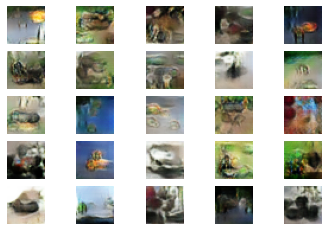

In [101]:
show_plot(X, 5)

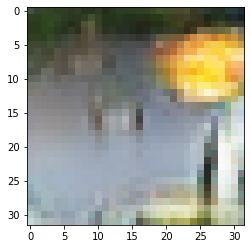

In [118]:
plt.imshow(X[0])

In [119]:
!zip -r /content/generator.zip /content/generator

  adding: content/generator/ (stored 0%)
  adding: content/generator/variables/ (stored 0%)
  adding: content/generator/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/generator/variables/variables.index (deflated 52%)
  adding: content/generator/assets/ (stored 0%)
  adding: content/generator/saved_model.pb (deflated 90%)
